# online market simulator

## part1 : data preparation

In [1]:
from preparation.preparation import load_data,clean_data, summarize_data 

df = load_data("data.xlsx")
df_clean = clean_data(df)
summary = summarize_data(df_clean)
summary.head()
print(summary)

✅ Data loaded successfully! Shape: (525461, 8)
✅ Data cleaned! Remaining rows: 504731
✅ Summary created! 4495 unique products.
                           Description   AvgPrice  TotalQuantity  \
0                *boombox ipod classic  16.980000              1   
1             *usb office glitter lamp   8.650000              1   
2              *usb office mirror ball   8.650000              1   
3               10 colour spaceboy pen   0.980816           6142   
4       11 pc ceramic tea set polkadot   4.950000              3   
...                                ...        ...            ...   
4490      zinc heart lattice tray oval   5.971364            326   
4491       zinc metal heart decoration   1.387674          14120   
4492           zinc police box lantern   7.395000            195   
4493     zinc top  2 door wooden shelf  12.159091            237   
4494  zinc willie winkie  candle stick   1.085273           3950   

      UniqueCustomers  
0                   0  
1       

## part 2 : modeling sellers (you can see seller implementation in modeling package)

### example of sellers and their influencers network

In [ ]:
from modeling.seller import Seller, create_sellers_for_product,get_multi_price_products
from random import randint
import pandas as pd

# get top multi price products
top_products = get_multi_price_products(df_clean)
# print(top_products)
# Create sellers
all_sellers: dict[str, list[Seller]] = {}

for product in top_products:
    sellers = create_sellers_for_product(df_clean, product)
    all_sellers[product] = sellers

for product, sellers in all_sellers.items():
    influence_scores = {s.name: randint(3, 8) for s in sellers}  # random influence
    for s in sellers:
        s.compute_demand(sellers, influence_scores[s.name])
        s.compute_profit()


results = []
for product, sellers in all_sellers.items():
    for s in sellers:
        results.append(s.info() | {"Product": product})

df_results = pd.DataFrame(results)


df_results


,Seller,Price,Ads,Demand,Profit,Product
0,10 colour spaceboy pen_Seller_1,0.72,12,65.91,16.47,10 colour spaceboy pen
1,10 colour spaceboy pen_Seller_2,0.85,14,65.56,22.84,10 colour spaceboy pen
2,10 colour spaceboy pen_Seller_3,1.66,7,57.90,72.44,10 colour spaceboy pen
3,10 colour spaceboy pen_Seller_4,2.51,10,56.13,114.73,10 colour spaceboy pen
4,12 ass zinc christmas decorations_Seller_1,2.10,5,64.81,76.66,12 ass zinc christmas decorations
5,12 ass zinc christmas decorations_Seller_2,4.21,12,58.98,186.76,12 ass zinc christmas decorations
6,12 ass zinc christmas decorations_Seller_3,4.30,14,58.71,189.14,12 ass zinc christmas decorations
7,12 coloured party balloons_Seller_1,0.55,7,58.33,12.25,12 coloured party balloons
8,12 coloured party balloons_Seller_2,0.65,10,63.53,17.32,12 coloured party balloons
9,12 coloured party balloons_Seller_3,1.28,7,57.14,53.57,12 coloured party balloons


## part3 : market simulation and Nash Equilibrium

In [3]:
from market.simulation import simulate_market


# Simulate market dynamics
sellers_eq, history = simulate_market(sellers, influence_scores)

# Print final equilibrium states
print("\n🎯 Final Equilibrium States:")
for s in sellers_eq:
    print(f"{s.name}: Price={s.price:.2f}, Ads={s.ad_budget:.2f}, Profit={s.profit:.2f}")

print(history)

Iteration   0 → Total Profit=1732.55, Avg Price=13.17
Iteration  10 → Total Profit=7731.20, Avg Price=38.97
Iteration  20 → Total Profit=13643.86, Avg Price=56.07
Iteration  30 → Total Profit=19837.46, Avg Price=70.07
Iteration  40 → Total Profit=27123.06, Avg Price=84.07
Iteration  50 → Total Profit=35500.66, Avg Price=98.07
Iteration  60 → Total Profit=44970.26, Avg Price=112.07
Iteration  70 → Total Profit=55531.86, Avg Price=126.07
Iteration  80 → Total Profit=67185.46, Avg Price=140.07
Iteration  90 → Total Profit=79931.06, Avg Price=154.07
Iteration 100 → Total Profit=93768.66, Avg Price=168.07
Iteration 110 → Total Profit=108698.26, Avg Price=182.07
Iteration 120 → Total Profit=124719.86, Avg Price=196.07
Iteration 130 → Total Profit=141833.46, Avg Price=210.07
Iteration 140 → Total Profit=160039.06, Avg Price=224.07
Iteration 150 → Total Profit=179336.66, Avg Price=238.07
Iteration 160 → Total Profit=199726.26, Avg Price=252.07
Iteration 170 → Total Profit=221207.86, Avg Price=

plot the simulation iteration

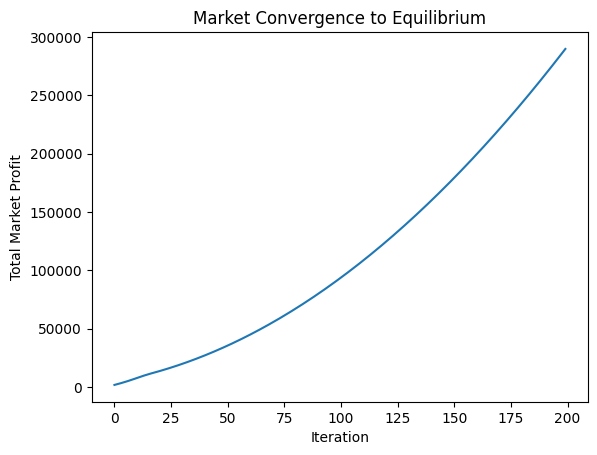

In [4]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Total Market Profit")
plt.title("Market Convergence to Equilibrium")
plt.show()